# part0: imports

In [5]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
import scipy.stats as stats
from sklearn.linear_model import Ridge, LinearRegression, SGDClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
%matplotlib inline
%config InlineBackend.figure_formats = ['png2x']


if "__file__" not in dir():
    # Global params
    classifier_model = GaussianNB
    classifier_params = {}

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root

finally:
    os.chdir(nbPath)


if "__file__" not in dir():
    %run "_dataset-selection.ipynb"

the variable `GoodDataList` contains the session names


# universal decoding of target using a model trained on a different animal


Train one decoder and use it to decode the target in other animals.  
The logic follows:  
CCA gives us: $X_1A\cong X_2B$  
Then: $X_1 \cong X_2BA^{-1}$  
So, we can train a decoder on $X_1$ and, then align any $X_2$ to $X_1$ to get $A$ and $B$.  
The same decoder should work on $X_2BA^{-1}$ as input.

In [6]:
if "__file__" not in dir():
    full_list = []
    for area in ('dualArea','PMd'):
        for animal, sessionList in GoodDataList[area].items():
            if 'Mr' in animal:
                continue  # to remove MrT
            full_list.append((animal,sessionList))
    full_list = [(animal,session) for animal,sessions in full_list for session in set(sessions)]

    # load the DFs
    warnings.filterwarnings("ignore")
    allDFs = []
    for animal, session in full_list:
        path = root/animal/session
        allDFs.append(prep_general(dt.load_pyal_data(path)))
    warnings.filterwarnings("default")

In [7]:
pairIndex_uni = []
for i, (animal1,session1) in enumerate(full_list):
    pairIndex_uni.append((i,[]))
    for j, (animal2,session2) in enumerate(full_list):
        if animal1 == animal2: continue
        if 'Chewie' in animal1 and 'Chewie' in animal2: continue
        pairIndex_uni[-1][1].append(j)

In [8]:
rng = np.random.default_rng(12345)
warnings.filterwarnings("ignore")
reg_scores = []
for id1, testList in pairIndex_uni:
    AllData = dt.get_data_array([allDFs[id1]]+[allDFs[testid] for testid in testList], exec_epoch, area=areas[0], model=n_components)
    # adding history -- there is no need for history
    AllData = dt.add_history_to_data_array(AllData, MAX_HISTORY)

    AllData1 = AllData[0,...] 
    _,n_trial,n_time,n_comp = AllData1.shape
    # resizing
    X1 = AllData1.reshape((-1,n_time*n_comp))
    AllTar = np.repeat(np.arange(8),n_trial)

    trial_index = np.arange(len(AllTar))
    # to guarantee shuffled ids
    while ((all_id_sh := rng.permutation(trial_index)) == trial_index).all():
        continue
    trial_index = all_id_sh
    X_train, Y_train = X1[trial_index,:], AllTar[trial_index]

    # train the decoder
    classifier = classifier_model(**classifier_params)
    classifier.fit(X_train, Y_train)
    X1 = AllData1.reshape((-1,n_comp))

    for testId,_ in enumerate(testList):
        AllData2 = AllData[testId+1,...]  # index-0 is for the training dataset above
        # resizing
        X2 = AllData2.reshape((-1,n_comp))
        
        # align the decoder
        A,B,*_ = dt.canoncorr(X1, X2, fullReturn=True)
        X2_aligned = X2 @ B @ linalg.inv(A) 

        X2_aligned = X2_aligned.reshape((-1,n_time*n_comp))
        AllTar = np.repeat(np.arange(8),n_trial)
        
        rng.shuffle(trial_index)
        X_test, Y_test = X2_aligned[trial_index,:], AllTar[trial_index]

        # test the decoder
        _score = classifier.score(X_test,Y_test)
        reg_scores.append((id1,testId,_score))
warnings.filterwarnings("default")

pop_score_uni = []
for _,_,scores in reg_scores:
    pop_score_uni.append(scores)
pop_score_uni = np.array(pop_score_uni)

if "__file__" not in dir():
    print('Done!')

Done!


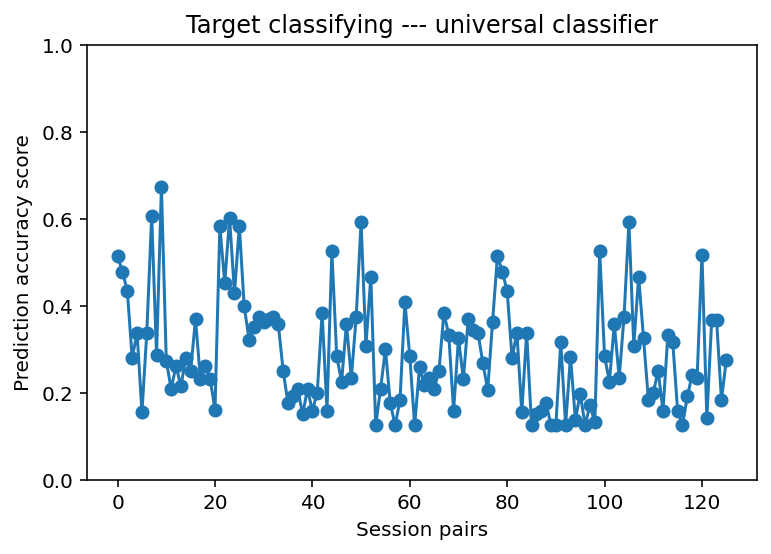

In [10]:
if "__file__" not in dir():
    _,ax = plt.subplots()
    ax.plot(pop_score_uni,'-o')
    ax.set_ylim([0,1])
    ax.set_xlabel('Session pairs')
    ax.set_ylabel('Prediction accuracy score')
    ax.set_title('Target classifying --- universal classifier')

# Universal decoding for within animal, across sessions

The same as the NN paper

In [11]:
if "__file__" not in dir():
    pairIndex_animal = []
    for i, (animal1,session1) in enumerate(full_list):
        pairIndex_animal.append((i,[]))
        for j, (animal2,session2) in enumerate(full_list):
            if animal1 != animal2: continue
            if session1 == session2: continue
            pairIndex_animal[-1][1].append(j)

In [12]:
if "__file__" not in dir():
    rng = np.random.default_rng(12345)
    warnings.filterwarnings("ignore")
    reg_scores = []
    for id1, testList in pairIndex_animal:
        AllData = dt.get_data_array([allDFs[id1]]+[allDFs[testid] for testid in testList], prep_epoch, area=areas[1], model=n_components)
        # adding history -- there is no need for history
        AllData = dt.add_history_to_data_array(AllData, MAX_HISTORY)

        AllData1 = AllData[0,...] 
        _,n_trial,n_time,n_comp = AllData1.shape
        # resizing
        X1 = AllData1.reshape((-1,n_time*n_comp))
        AllTar = np.repeat(np.arange(8),n_trial)

        trial_index = np.arange(len(AllTar))
        # to guarantee shuffled ids
        while ((all_id_sh := rng.permutation(trial_index)) == trial_index).all():
            continue
        trial_index = all_id_sh
        X_train, Y_train = X1[trial_index,:], AllTar[trial_index]

        # train the decoder
        classifier = classifier_model(**classifier_params)
        classifier.fit(X_train, Y_train)

        for testId,_ in enumerate(testList):
            AllData2 = AllData[testId+1,...]  # index-0 is for the training dataset above
            # resizing
            X1 = AllData1.reshape((-1,n_comp))
            X2 = AllData2.reshape((-1,n_comp))

            # align the decoder
            A,B,*_ = dt.canoncorr(X1, X2, fullReturn=True)
            X2_aligned = X2 @ B @ linalg.inv(A) 

            X2_aligned = X2_aligned.reshape((-1,n_time*n_comp))
            AllTar = np.repeat(np.arange(8),n_trial)

            rng.shuffle(trial_index)
            X_test, Y_test = X2_aligned[trial_index,:], AllTar[trial_index]

            # test the decoder
            _score = classifier.score(X_test,Y_test)
            reg_scores.append((id1,testId,_score))
    warnings.filterwarnings("default")

    pop_score_uni = []
    for _,_,scores in reg_scores:
        pop_score_uni.append(scores)
    pop_score_uni = np.array(pop_score_uni)

    print('Done!')

Done!


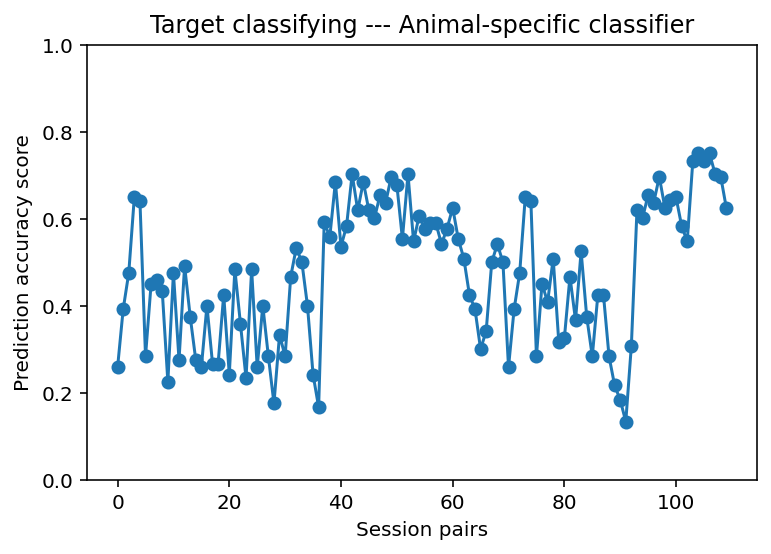

In [13]:
if "__file__" not in dir():
    _,ax = plt.subplots()
    ax.plot(pop_score_uni,'-o')
    ax.set_ylim([0,1])
    ax.set_xlabel('Session pairs')
    ax.set_ylabel('Prediction accuracy score')
    ax.set_title('Target classifying --- Animal-specific classifier')